In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor
import optuna

CPU times: user 1.76 s, sys: 1.21 s, total: 2.97 s
Wall time: 2.34 s


In [2]:
df = pd.read_csv("train.csv", low_memory = False)
dep_var = "num_sold"

In [3]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [4]:
%%time
import pickle

country_map = pickle.load(open("embs/country_map.pkl", "rb"))
product_map = pickle.load(open("embs/product_map.pkl", "rb"))
store_map = pickle.load(open("embs/store_map.pkl", "rb"))

CPU times: user 2.52 ms, sys: 1.38 ms, total: 3.9 ms
Wall time: 2.28 ms


In [5]:
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_country = pd.DataFrame(df['country'].map(country_map).to_list(), columns = col_name)

emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_product = pd.DataFrame(df['product'].map(product_map).to_list(), columns = col_name)

emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_store = pd.DataFrame(df['store'].map(store_map).to_list(), columns = col_name)

In [6]:
df_tr = pd.concat([df[["date", "num_sold"]], df_emb_store, df_emb_product, df_emb_country], axis = 1)

In [7]:
df_tr = add_datepart(df_tr, 'date')

In [8]:
df_tr.head()

,num_sold,store_emb_1,store_emb_2,store_emb_3,product_emb_1,product_emb_2,product_emb_3,country_emb_1,country_emb_2,country_emb_3,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,329,-0.624793,0.573543,-0.623404,0.280270,-0.364885,0.267398,0.427736,0.64916,0.595577,...,1,3,1,False,True,False,True,False,True,1.420070e+09
1,520,-0.624793,0.573543,-0.623404,-0.197140,-0.092194,-0.153508,0.427736,0.64916,0.595577,...,1,3,1,False,True,False,True,False,True,1.420070e+09
2,146,-0.624793,0.573543,-0.623404,0.756201,-0.683068,0.854909,0.427736,0.64916,0.595577,...,1,3,1,False,True,False,True,False,True,1.420070e+09
3,572,-0.365417,-0.264811,-0.517483,0.280270,-0.364885,0.267398,0.427736,0.64916,0.595577,...,1,3,1,False,True,False,True,False,True,1.420070e+09
4,911,-0.365417,-0.264811,-0.517483,-0.197140,-0.092194,-0.153508,0.427736,0.64916,0.595577,...,1,3,1,False,True,False,True,False,True,1.420070e+09


In [9]:
df_tr.columns

Index(['num_sold', 'store_emb_1', 'store_emb_2', 'store_emb_3',
       'product_emb_1', 'product_emb_2', 'product_emb_3', 'country_emb_1',
       'country_emb_2', 'country_emb_3', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed'],
      dtype='object')

In [11]:
month_map = pickle.load(open("embs/month_map.pkl", "rb"))

month_map[1].shape

(7,)

In [13]:
emb_dim = month_map[1].shape[0]
col_name = [f'month_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_month = pd.DataFrame(df_tr['Month'].map(month_map).to_list(), columns = col_name)

In [14]:
df_emb_month.head()

,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7
0,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
1,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
2,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
3,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
4,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343


In [15]:
df_tr = pd.concat([df_tr, df_emb_month], axis = 1)

In [16]:
df_tr.head()

,num_sold,store_emb_1,store_emb_2,store_emb_3,product_emb_1,product_emb_2,product_emb_3,country_emb_1,country_emb_2,country_emb_3,...,Is_year_end,Is_year_start,Elapsed,month_emb_1,month_emb_2,month_emb_3,month_emb_4,month_emb_5,month_emb_6,month_emb_7
0,329,-0.624793,0.573543,-0.623404,0.280270,-0.364885,0.267398,0.427736,0.64916,0.595577,...,False,True,1.420070e+09,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
1,520,-0.624793,0.573543,-0.623404,-0.197140,-0.092194,-0.153508,0.427736,0.64916,0.595577,...,False,True,1.420070e+09,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
2,146,-0.624793,0.573543,-0.623404,0.756201,-0.683068,0.854909,0.427736,0.64916,0.595577,...,False,True,1.420070e+09,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
3,572,-0.365417,-0.264811,-0.517483,0.280270,-0.364885,0.267398,0.427736,0.64916,0.595577,...,False,True,1.420070e+09,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343
4,911,-0.365417,-0.264811,-0.517483,-0.197140,-0.092194,-0.153508,0.427736,0.64916,0.595577,...,False,True,1.420070e+09,-0.021981,0.11004,0.244673,-0.043323,-0.111131,0.070589,0.051343


In [17]:
cond = (df_tr.Year < 2018)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [26]:
splits = (list(train_idx), list(valid_idx))
cont, cat = cont_cat_split(df_tr, 5000, dep_var)

In [27]:
procs = [Categorify, FillMissing]
to = TabularPandas(df_tr, procs, cat, cont, y_names = dep_var, splits = splits)

In [28]:
cont

['store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'Elapsed',
 'month_emb_1',
 'month_emb_2',
 'month_emb_3',
 'month_emb_4',
 'month_emb_5',
 'month_emb_6',
 'month_emb_7']

In [29]:
cat

['Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [30]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [31]:
def cal_smape(preds, targs):
    total = len(targs)
    smp = 0
    for i,j in zip(preds, targs):
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smp += fin
        
    smp = (smp/total) * 100 
    
    return smp

In [32]:
a,b,c,d,e = [],[],[],[],[]
score = []

g_index = 1
def hp_tuning(trial) :
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.5, log = True)
    gamma = trial.suggest_float("gamma", 0.001, 10)
    alpha = trial.suggest_float("alpha", 0.001, 10)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 0.001, 25)
    
    model = XGBRegressor(verbosity = 0, alpha = alpha, reg_lambda = reg_lambda, gamma = gamma, max_depth = max_depth, learning_rate = learning_rate)
    
    model.fit(xs, y)
                            
    preds_val = model.predict(valid_xs)
   
        
    a.append(learning_rate)
    b.append(gamma)
    c.append(alpha)
    d.append(max_depth)
    e.append(reg_lambda)
    score.append(cal_smape(preds_val, valid_y))
    
        
        
    return (cal_smape(preds_val, valid_y))

In [33]:
study = optuna.create_study(direction = "minimize")
study.optimize(hp_tuning, n_trials=500)
print('Number of finished trials:', len(study.trials))
print("Best Params: ",study.best_params)

[I 2022-01-12 04:41:02,429] A new study created in memory with name: no-name-e88859ee-357a-4cea-9b56-8a3795881d1b
[I 2022-01-12 04:41:05,222] Trial 0 finished with value: 8.249117874817793 and parameters: {'learning_rate': 0.08499061067010519, 'gamma': 9.788316017207816, 'alpha': 7.794977340977294, 'max_depth': 14, 'reg_lambda': 0.0024273713162799933}. Best is trial 0 with value: 8.249117874817793.
[I 2022-01-12 04:41:05,740] Trial 1 finished with value: 123.2115702126124 and parameters: {'learning_rate': 0.0030004031891173394, 'gamma': 2.810706474402225, 'alpha': 5.874568439837026, 'max_depth': 4, 'reg_lambda': 0.33448918683481527}. Best is trial 0 with value: 8.249117874817793.
[I 2022-01-12 04:41:06,465] Trial 2 finished with value: 195.44357797295564 and parameters: {'learning_rate': 0.00010981082134122484, 'gamma': 0.5160066491063658, 'alpha': 7.077616231364125, 'max_depth': 6, 'reg_lambda': 1.6497545306675074}. Best is trial 0 with value: 8.249117874817793.
[I 2022-01-12 04:41:06

Number of finished trials: 500
Best Params:  {'learning_rate': 0.05207536502852557, 'gamma': 4.502275297239194, 'alpha': 3.3168683621496244, 'max_depth': 8, 'reg_lambda': 0.014396970332465212}


In [34]:
print("Best Params: ",study.best_params)

Best Params:  {'learning_rate': 0.05207536502852557, 'gamma': 4.502275297239194, 'alpha': 3.3168683621496244, 'max_depth': 8, 'reg_lambda': 0.014396970332465212}


In [35]:
model = XGBRegressor(learning_rate = study.best_params['learning_rate'], gamma = study.best_params['gamma'],
                     alpha = study.best_params['alpha'], max_depth = study.best_params['max_depth'],
                     reg_lambda = study.best_params['reg_lambda'])

In [36]:
model.fit(xs, y)

XGBRegressor(alpha=3.3168683621496244, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=4.502275297239194, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05207536502852557, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=3.31686831,
             reg_lambda=0.014396970332465212, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
cal_smape(model.predict(xs), y)

4.121421843911426

In [38]:
cal_smape(model.predict(valid_xs), valid_y)

7.160103317440021

In [39]:
test = pd.read_csv("test.csv")
test["num_sold"] = 0
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_country = pd.DataFrame(test['country'].map(country_map).to_list(), columns = col_name)

emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_product = pd.DataFrame(test['product'].map(product_map).to_list(), columns = col_name)

emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_store = pd.DataFrame(test['store'].map(store_map).to_list(), columns = col_name)


In [40]:
cols = xs.columns

In [41]:
test_fn = pd.concat([test[["date", "num_sold"]],test_emb_country, test_emb_product, test_emb_store ], axis = 1)

In [42]:
test_fn = add_datepart(test_fn, 'date')

In [43]:
emb_dim = month_map[1].shape[0]
col_name = [f'month_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_month = pd.DataFrame(test_fn['Month'].map(month_map).to_list(), columns = col_name)

In [44]:
test_fn = pd.concat([test_fn, test_emb_month], axis = 1)

In [45]:
to_test = TabularPandas(test_fn, procs, cat, cont, y_names = dep_var, splits = None)

In [46]:
test_xs = to_test.train.xs

In [47]:
preds_test = model.predict(test_xs)

In [48]:
preds_test

array([ 304.0204 ,  481.66882,  133.66125, ...,  863.4396 , 1635.0586 ,
        444.41525], dtype=float32)

In [49]:
ids = list(test["row_id"].values)
submission = pd.DataFrame()
submission["row_id"] = ids
submission["num_sold"] = list(preds_test)

In [50]:
submission.to_csv("submission.csv", index = False)

In [51]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)

In [52]:
fi = rf_feat_importance(model, xs)
fi[:10]

,cols,imp
15,product_emb_1,0.672065
12,store_emb_1,0.179317
23,month_emb_2,0.065186
18,country_emb_1,0.034064
25,month_emb_4,0.010154
4,Dayofweek,0.008008
5,Dayofyear,0.007916
28,month_emb_7,0.004500
1,Month,0.003908
2,Week,0.002999


In [53]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize = (12, 7), legend = False)

<AxesSubplot:ylabel='cols'>

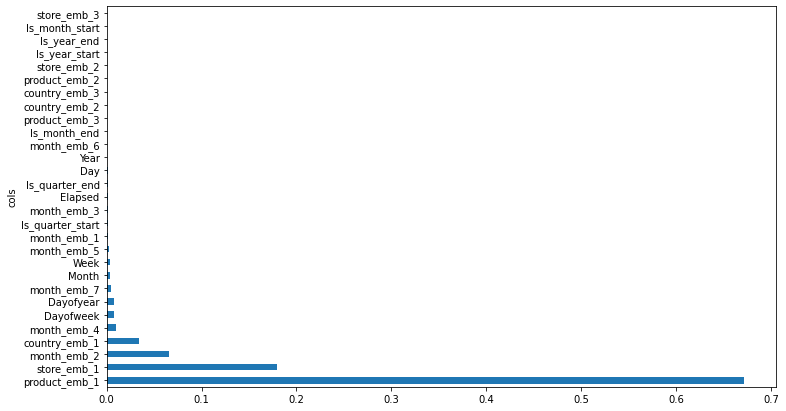

In [54]:
plot_fi(fi[:30])

In [55]:
to_keep = fi[fi.imp>0.005].cols

len(to_keep)

7

In [56]:
to_keep

15    product_emb_1
12      store_emb_1
23      month_emb_2
18    country_emb_1
25      month_emb_4
4         Dayofweek
5         Dayofyear
Name: cols, dtype: object

In [57]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [58]:
model = XGBRegressor(learning_rate = study.best_params['learning_rate'], gamma = study.best_params['gamma'],
                     alpha = study.best_params['alpha'], max_depth = study.best_params['max_depth'],
                     reg_lambda = study.best_params['reg_lambda'])

In [59]:
model.fit(xs_imp, y)

XGBRegressor(alpha=3.3168683621496244, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=4.502275297239194, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05207536502852557, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=7, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=3.31686831,
             reg_lambda=0.014396970332465212, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
cal_smape(model.predict(xs_imp), y)

5.841299158935584

In [64]:
cal_smape(model.predict(valid_xs_imp), valid_y)

12.440880571542843

In [65]:
test_xs = test_xs[to_keep]
preds_test = model.predict(test_xs)

In [66]:
ids = list(test["row_id"].values)
submission = pd.DataFrame()
submission["row_id"] = ids
submission["num_sold"] = list(preds_test)

In [67]:
preds_test

array([ 329.1715 ,  497.52258,  135.52821, ...,  890.0403 , 1377.3887 ,
        405.13718], dtype=float32)

In [68]:
submission.to_csv("submission.csv", index = False)

In [70]:
! kaggle competitions submit -c tabular-playground-series-jan-2022 -f submission.csv -m "whgggg"

100%|████████████████████████████████████████| 101k/101k [00:04<00:00, 21.0kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022